# Tutorial 04 - Optimizing Force Fields

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/openforcefield/openff-evaluator/blob/main/docs/tutorials/tutorial04.ipynb)

In this tutorial we will be using the OpenFF Evaluator framework in combination with the fantastic [*ForceBalance*](
https://github.com/leeping/forcebalance) software to optimize a molecular force field against the physical property data 
set we created in the [first tutorial](tutorial01.ipynb).

*ForceBalance* offers a suite of tools for optimizing molecular force fields against a set of target data. Perhaps one of 
the most fundamental targets to fit against is experimental physical property data. Physical property data has been used 
extensively for decades to inform the values of non-bonded Van der Waals (VdW) interaction parameters (often referred to 
as Lennard-Jones parameters).

*ForceBalance* is seamlessly integrated with the evaluator framework, using it to evaluate the deviations between
target experimentally measured data points and those evaluated using the force field being optimized (as well as the 
gradient of those deviations with respect to the force field parameters being optimized).

The tutorial will cover:

- setting up the input files and directory structure required by ForceBalace.
- setting up an `EvaluatorServer` for *ForceBalance* to connect to.
- running *ForceBalance* using those input files.
- extracting and plotting a number of statistics output during the optimization.

*Note: If you are running this tutorial in google colab you will need to run a setup script instead of following the 
installation instructions:*

In [1]:
# !wget https://raw.githubusercontent.com/openforcefield/openff-evaluator/main/docs/tutorials/colab_setup.ipynb
# %run colab_setup.ipynb

*For this tutorial make sure that you are using a GPU accelerated runtime.*

For the sake of clarity all warnings will be disabled in this tutorial:

In [2]:
import warnings

warnings.filterwarnings("ignore")
import logging

logging.getLogger("openforcefield").setLevel(logging.ERROR)

We will also enable time-stamped logging to help track the progress of our calculations:

In [3]:
from openff.evaluator.utils import setup_timestamp_logging

setup_timestamp_logging()

## Setting up the ForceBalance Inputs

In this section we will be creating the directory structure required by *ForceBalance*, and populating it with the 
required input files.

### Creating the Directory Structure

To begin with, we will create a directory to store the starting force field parameters in:

In [4]:
!mkdir forcefield

mkdir: cannot create directory ‘forcefield’: File exists


and one to store the input parameters for our 'fitting target' - in this case a data set of physical properties:

In [5]:
!mkdir -p targets/pure_data

### Defining the Training Data Set

With the directories created, we will next specify the data set of physical properties which we will be training the 
force field against:

In [6]:
# For convenience we will use the copy shipped with the framework
from openff.evaluator.utils import get_data_filename

data_set_path = get_data_filename("tutorials/tutorial01/filtered_data_set.json")

# Load the data set.
from openff.evaluator.datasets import PhysicalPropertyDataSet

data_set = PhysicalPropertyDataSet.from_json(data_set_path)

# Due to a small bug in ForceBalance we need to zero out any uncertainties
# which are undefined. This will be fixed in future versions.
from openff.evaluator.attributes import UNDEFINED

for physical_property in data_set:
    if physical_property.uncertainty != UNDEFINED:
        continue

    physical_property.uncertainty = 0.0 * physical_property.default_unit()

To speed up the runtime of this tutorial, we will only train the force field against measurements made for ethanol

In [7]:
from openff.evaluator.datasets.curation.components.filtering import (
    FilterBySmiles,
    FilterBySmilesSchema,
)

data_set = FilterBySmiles.apply(
    data_set,
    FilterBySmilesSchema(smiles_to_include=["CCO"]),
)

2023-02-12 12:52:22.703 INFO     2 data points were removed after applying the FilterBySmiles component.


in real optimizations however the data set should be **much** larger than two data points!

With those changes made, we can save the data set in our targets directory:

In [8]:
# Store the data set in the `pure_data` targets folder:
data_set.json("targets/pure_data/training_set.json");

### Defining the Starting Force Field Parameters

We will use the OpenFF Parsley 1.0.0 force field as the starting parameters for the optimization. These can be loaded
directly into an OpenFF `ForceField` object using the OpenFF toolkit:

In [9]:
from openff.toolkit.typing.engines.smirnoff import ForceField

force_field = ForceField("openff-1.0.0.offxml")

2023-02-12 12:52:23.261 INFO     Attempting to up-convert Electrostatics section from 0.3 to 0.4
2023-02-12 12:52:23.262 INFO     Successfully up-converted Electrostatics section from 0.3 to 0.4. `method="PME"` is now split into `periodic_potential="Ewald3D-ConductingBoundary"`, `nonperiodic_potential="Coulomb"`, and `exception_potential="Coulomb"`.


In order to use these parameters in *ForceBalance*, we need to 'tag' the individual parameters in the force field that
we wish to optimize. The toolkit easily enables us to add these tags using cosmetic attributes:

In [10]:
# Extract the smiles of all unique components in our data set.
from openff.toolkit.topology import Molecule, Topology

all_smiles = {
    component.smiles
    for substance in data_set.substances
    for component in substance.components
}

for smiles in all_smiles:
    # Find those VdW parameters which would be applied to those components.
    molecule = Molecule.from_smiles(smiles)
    topology = Topology.from_molecules([molecule])

    labels = force_field.label_molecules(topology)[0]

    # Tag the exercised parameters as to be optimized.
    for parameter in labels["vdW"].values():
        parameter.add_cosmetic_attribute("parameterize", "epsilon, rmin_half")

Here we have made use of the toolkit's handy `label_molecules` function to see which VdW parameters will be assigned
to the molecules in our data set, and tagged them to be parameterized.

With those tags added, we can save the parameters in the `forcefield` directory:

In [11]:
# Save the annotated force field file.
force_field.to_file("forcefield/openff-1.0.0-tagged.offxml")

*Note: The force field parameters are stored in the [OpenFF SMIRNOFF XML format](https://open-forcefield-toolkit.readthedocs.io/en/0.6.0/smirnoff.html).*

### Creating the Main Input File

Next, we will create the main *ForceBalance* input file. For the sake of brevity a default input file which ships with 
this framework will be used:

In [12]:
input_file_path = get_data_filename("tutorials/tutorial04/optimize.in")

# Copy the input file into our directory structure
import shutil

shutil.copyfile(input_file_path, "optimize.in")

'optimize.in'

While there are many options that can be set within this file, the main options of interest for our purposes appear
at the bottom of the file:

In [13]:
!tail -n 6 optimize.in

$target
name pure_data
type Evaluator_SMIRNOFF
weight 1.0
evaluator_input options.json
$end

Here we have specified that we wish to create a new *ForceBalance* `Evaluator_SMIRNOFF` target called `pure_data` 
(corresponding to the name of the directory we created in the earlier step).
 
The main input to this target is the file path to an `options.json` file - it is this file which will specify all the
options which should be used when *ForceBalance* requests that our target data set be estimated using the current sets
of force field parameters.

We will create this file in the `targets/pure_data` directory later in this section.

The data set is the JSON serialized representation of the `PhysicalPropertyDataSet` we created during the [first 
tutorial](tutorial01.ipynb).

### Defining the Estimation Options

The final step before we can start the optimization is to create the set of options which will govern how our data set
is estimated using the Evaluator framework.
 
These options will be stored in an `Evaluator_SMIRNOFF` object:

In [14]:
from forcebalance.evaluator_io import Evaluator_SMIRNOFF

# Create the ForceBalance options object
target_options = Evaluator_SMIRNOFF.OptionsFile()
# Set the path to the data set
target_options.data_set_path = "training_set.json"

2023-02-12 12:52:24.104 WARNING  Warning: importing 'simtk.openmm' is deprecated.  Import 'openmm' instead.


This object exposes both a set of *ForceBalance* specific options, as well as the set of Evaluator options. 

The *ForceBalance* specific options allow us to define how each type of property will contribute to the optimization
objective function (the value which we are trying to minimize):

$$\Delta(\theta) = \sum^N_n \dfrac{weight_n}{M_n} \sum^{M_n}_m \left(\dfrac{y_m^{ref} - y_m(\theta)}{denominator_{n}}\right)^2$$ 

where $N$ is the number of types of properties (e.g. density, enthalpy of vaporization, etc.), $M_n$ is the number of
data points of type $n$, $y_m^{ref}$ is the experimental value of data point $m$ and $y_m(\theta)$ is the estimated 
value of data point $m$ using the current force field parameters

In particular, the options object allows us to specify both an amount to scale each type of properties contribution to 
the objective function by ($weight_n$), and the amount to scale the difference between the experimental and estimated
properties ($denominator_n$):

In [15]:
from openff.units import unit

target_options.weights = {"Density": 1.0, "EnthalpyOfVaporization": 1.0}
target_options.denominators = {
    "Density": 30.0 * unit.kilogram / unit.meter**3,
    "EnthalpyOfVaporization": 3.0 * unit.kilojoule / unit.mole,
}

 
where here we have chosen values that ensure that both types of properties contribute roughly equally to the total
objective function.

The Evaluator specific options correspond to a standard `RequestOptions` object:

In [16]:
from openff.evaluator.client import RequestOptions

# Create the options which evaluator should use.
evaluator_options = RequestOptions()
# Choose which calculation layers to make available.
evaluator_options.calculation_layers = ["SimulationLayer"]

# Reduce the default number of molecules
from openff.evaluator.properties import Density, EnthalpyOfVaporization

density_schema = Density.default_simulation_schema(n_molecules=256)
h_vap_schema = EnthalpyOfVaporization.default_simulation_schema(n_molecules=256)

evaluator_options.add_schema("SimulationLayer", "Density", density_schema)
evaluator_options.add_schema("SimulationLayer", "EnthalpyOfVaporization", h_vap_schema)

target_options.estimation_options = evaluator_options

These options allow us to control exactly how each type of property should be estimated, which calculation approaches
should be used and more. Here we use the same options are were used in the [second tutorial](tutorial02.ipynb)

*Note: more information about the different estimation options can be [found here](../gettingstarted/client.rst)*

And that's the options created! We will finish off by serializing the options into our target directory:

In [17]:
# Save the options to file.
with open("targets/pure_data/options.json", "w") as file:
    file.write(target_options.to_json())

## Launching an Evaluator Server

With the *ForceBalance* options created, we can now move onto launching the `EvaluatorServer` which *ForceBalance* will 
call out to when it needs the data set to be evaluated:

In [18]:
import os

# Launch the calculation backend which will distribute any calculations.
from openff.evaluator.backends import ComputeResources
from openff.evaluator.backends.dask import DaskLocalCluster

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

calculation_backend = DaskLocalCluster(
    number_of_workers=1,
    resources_per_worker=ComputeResources(
        number_of_threads=1,
        number_of_gpus=1,
        preferred_gpu_toolkit=ComputeResources.GPUToolkit.CUDA,
    ),
)
calculation_backend.start()

# Launch the server object which will listen for estimation requests and schedule any
# required calculations.
from openff.evaluator.server import EvaluatorServer

evaluator_server = EvaluatorServer(calculation_backend=calculation_backend)
evaluator_server.start(asynchronous=True)

2023-02-12 12:52:25.437 INFO     To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
2023-02-12 12:52:25.470 INFO     State start
2023-02-12 12:52:25.473 INFO       Scheduler at: inproc://172.18.240.125/3801/1
2023-02-12 12:52:25.474 INFO       dashboard at:            localhost:8787
2023-02-12 12:52:25.477 INFO     Found stale lock file and directory '/tmp/dask-worker-space/worker-fvyx2ber', purging
2023-02-12 12:52:25.478 INFO     Found stale lock file and directory '/tmp/dask-worker-space/worker-69aiok5o', purging
2023-02-12 12:52:25.483 INFO           Start worker at: inproc://172.18.240.125/3801/4
2023-02-12 12:52:25.484 INFO              Listening to:       inproc172.18.240.125
2023-02-12 12:52:25.485 INFO               Worker name:                          0
2023-02-12 12:52:25.486 INFO              dashboard at:       172.18.240.125:33181
2023-02-12 12:52:25.486 INFO     Waiting to connect to: inproc://172.1

We will not go into the details of this here as this was already covered in the [second tutorial](tutorial02.ipynb)

## Running ForceBalance

With the inputs created and an Evaluator server spun up, we are finally ready to run the optimization! This can be 
accomplished with a single command:

In [19]:
!ForceBalance optimize.in

Output will be written to optimize.out
#=====================================#
#|     For black and white mode,     |#
#|      Run this script with -b      |#
#=====================================#
#======================================================================#
#|             Welcome to ForceBalance version 1.9.5! =D              |#
#|                  Force Field Optimization System                   |#
#|                                                                    |#
#|                              Authors:                              |#
#|                           Lee-Ping Wang                            |#
#|                   Yudong Qiu, Keri A. McKiernan                    |#
#|           Jeffrey R. Wagner, Hyesu Jang, Simon Boothroyd           |#
#|           Arthur Vigil, Erik G. Brandt, John Stoppelman            |#
#|                   Johnny Israeli, Matt Thompson                    |#
#======================================================================

If everything went well *ForceBalance* should exit cleanly, and will have stored out newly optimized force field in the
`results` directory.

In [20]:
!ls result/optimize

openff-1.0.0-tagged.offxml  openff-1.0.0-tagged_1.offxml


## Plotting the results

As a last step in this tutorial, we will extract the objective function at each iteration from the *ForceBalance* output
files and plot this using `matplotlib`.

First, we will extract the objective function from the `pickle` serialized output files which can be found in the 
`optimize.tmp/pure_data/iter_****/` directories:

In [21]:
# Determine how many iterations ForceBalance has completed.
from glob import glob

from forcebalance.nifty import lp_load

n_iterations = len(glob("optimize.tmp/pure_data/iter*"))

# Extract the objective function at each iteration.
objective_function = []

for iteration in range(n_iterations):
    folder_name = "iter_" + str(iteration).zfill(4)
    file_path = f"optimize.tmp/pure_data/{folder_name}/objective.p"

    statistics = lp_load(file_path)
    objective_function.append(statistics["X"])

print(objective_function)

[1.2857821957553541, 0.14546087931784857]


The objective function is then easily plotted:

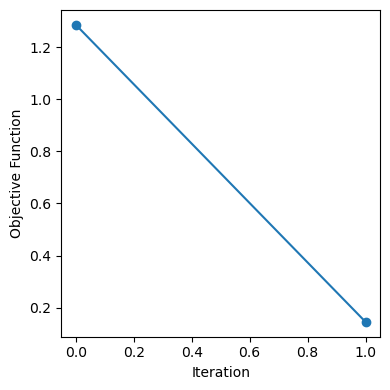

In [22]:
from matplotlib import pyplot

figure, axis = pyplot.subplots(1, 1, figsize=(4, 4))

axis.set_xlabel("Iteration")
axis.set_ylabel("Objective Function")

axis.plot(range(n_iterations), objective_function, marker="o")

figure.tight_layout()

## Conclusion

And that concludes the fourth tutorial! 

If you have any questions and / or feedback, please open an issue on the
[GitHub issue tracker](https://github.com/openforcefield/openff-evaluator/issues).